In [2]:
from importlib import reload
import matplotlib.pyplot as plt
from copy import deepcopy

import qiskit as qk
from qiskit import IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile, execute
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit.library import MCMT

In [3]:
import tools as t
reload(t)
from tools import counts, probs, job_id, circ, circ_measured

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
sim = qk.Aer.get_backend('qasm_simulator')
manila = provider.get_backend('ibmq_manila')
manila_sim = QasmSimulator.from_backend(manila)

In [5]:
t.list_jobs(manila)

  0 2021-12-30 20:11:32 61ce0464e867008868a03dfb DONE
  1 2021-12-30 20:11:28 61ce0460063519f0a5a7f86c DONE
  2 2021-12-30 19:55:43 61ce00af049a237bb0d1e7c6 DONE
  3 2021-12-30 19:54:05 61ce004d2ac6ddee4c4ccf63 DONE
  4 2021-12-30 13:17:37 61cda3610635195e17a7f6d6 DONE
  5 2021-12-30 13:17:33 61cda35dd6d3bc9fafd3030f DONE
  6 2021-12-30 13:17:30 61cda35a049a23ed99d1e643 DONE
  7 2021-12-29 20:31:34 61ccb796bf935fa878647bdd DONE
  8 2021-12-29 20:31:05 61ccb7797655695fb2672806 DONE
  9 2021-12-29 20:01:02 61ccb06e2ac6ddd12e4ccb31 DONE


In [7]:
# build A
qr, qc = circ(2)
qc.h(0)
qc.cnot(0, 1)
A_circ = deepcopy(qc)
B_circ = deepcopy(qc)

qr, qc = t.circ(4)
qc.compose(A_circ, qr[:2], inplace=True)
qc.compose(B_circ, qr[-2:], inplace=True)
qc.cnot(0, 3)
qc.h(0)
U_circ = deepcopy(qc)
U_dag_circ = deepcopy(qc.reverse_ops())

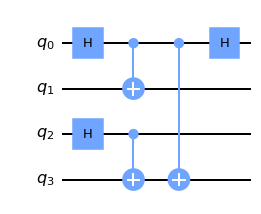

In [8]:
U_circ.draw()

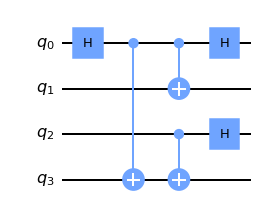

In [9]:
U_dag_circ.draw()

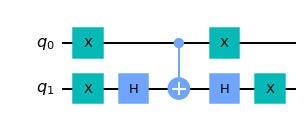

In [10]:
# build 2-qubit diffusion
D2_circ = deepcopy(t.S0_circuit(2))
O1_circ = deepcopy(D2_circ)
D2_circ.draw()

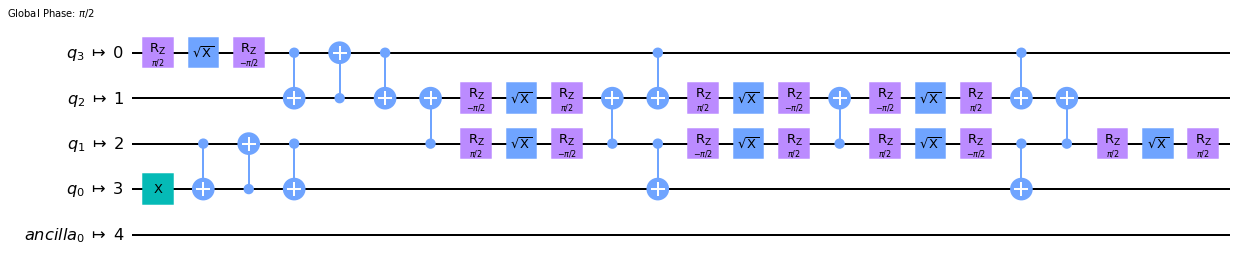

In [33]:
# build Q1
qr, qc = circ(4)
qc.compose(O1_circ, [0, -1], inplace=True)
# qc.barrier()
qc.compose(U_dag_circ, qr, inplace=True)
# qc.barrier()
qc.compose(D2_circ, [0, -1], inplace=True)
qc.compose(U_circ, qr, inplace=True)
Q1_circ = deepcopy(qc)
transpile(Q1_circ, backend=manila).draw()

In [15]:
# see number of iterations needed to have contraction 0 state

# build list of circuits
circ_lst = []
qr, cr, qc = circ_measured(4, 2)
qc.compose(U_circ, qr, inplace=True)

## iteration 0 (does not have Q operator)
qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure([0, -1], cr)
circ_lst.append(qc_measured)

for m in range(10):
    qc.compose(Q1_circ, qr, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure([0, -1], cr)
    circ_lst.append(qc_measured)

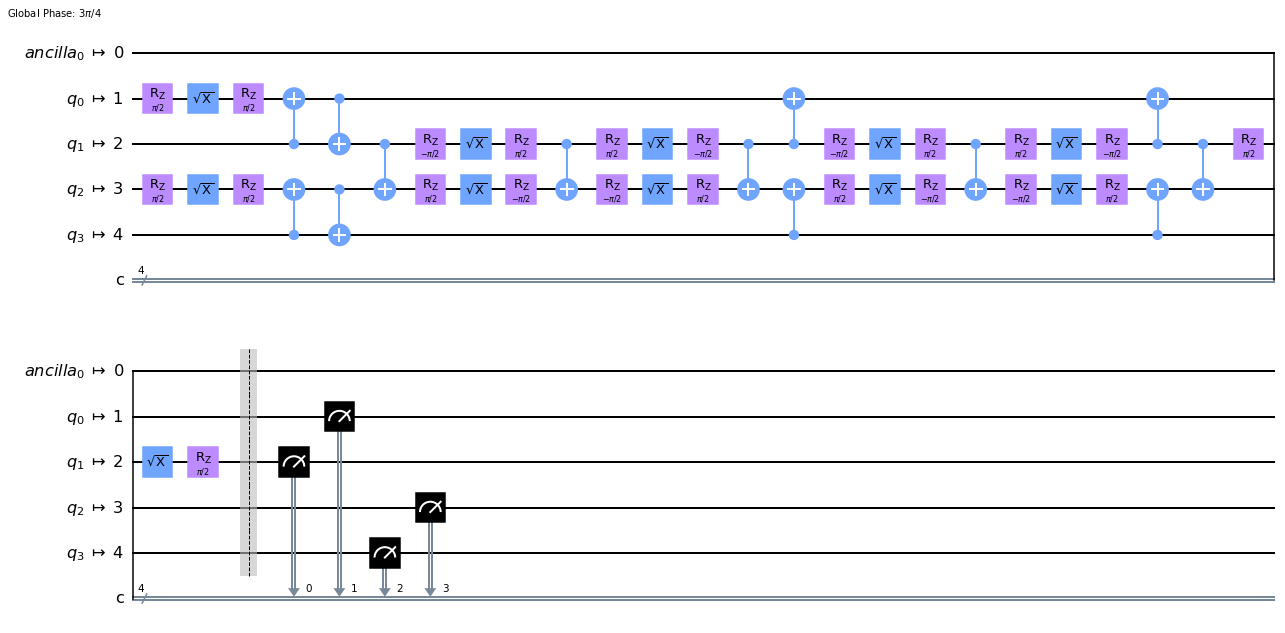

In [34]:
transpile(circ_lst[1], backend=manila).draw()

In [18]:
job0 = execute(circ_lst, backend=sim, shots=20000)

In [19]:
counts(job0)

[{'10': 4985, '01': 4978, '00': 4913, '11': 5124},
 {'00': 20000},
 {'10': 5109, '11': 5015, '00': 4975, '01': 4901},
 {'11': 5070, '10': 4877, '01': 4954, '00': 5099},
 {'00': 20000},
 {'10': 4964, '11': 5105, '01': 4972, '00': 4959},
 {'11': 4925, '10': 4972, '01': 5036, '00': 5067},
 {'00': 20000},
 {'11': 4977, '10': 5003, '01': 5086, '00': 4934},
 {'10': 4945, '11': 4963, '00': 5023, '01': 5069},
 {'00': 20000}]

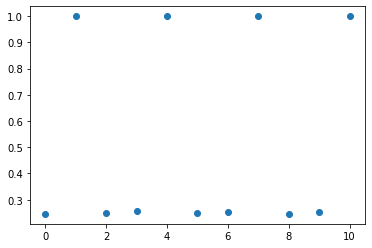

In [20]:
plt.plot(t.a_arr(counts(job0), '00'),'o')

seems like we need 1 iteration!

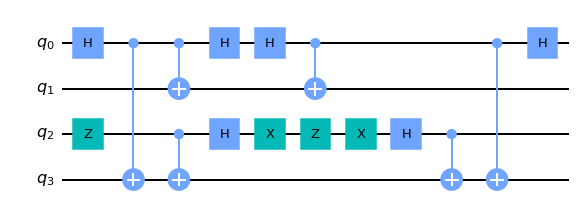

In [21]:
# build Q2 - first try
qr, qc = circ(4)
qc.z(2)
# qc.barrier()
qc.compose(U_dag_circ, qr, inplace=True)
# qc.barrier()
# qc.compose(D2_circ, [1, 2], inplace=True)
qc.x(2)
qc.z(2)
qc.x(2)
# qc.barrier()
qc.compose(U_circ, qr, inplace=True)
Q2_circ = deepcopy(qc)
Q2_circ.draw()

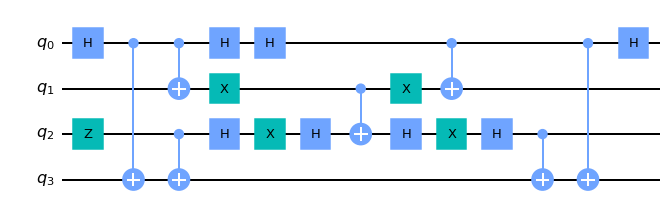

In [22]:
# build Q2 - second try
qr, qc = circ(4)
qc.z(2)
# qc.barrier()
qc.compose(U_dag_circ, qr, inplace=True)
# qc.barrier()
qc.compose(D2_circ, [1, 2], inplace=True)
# qc.barrier()
qc.compose(U_circ, qr, inplace=True)
Q2_circ = deepcopy(qc)
Q2_circ.draw()

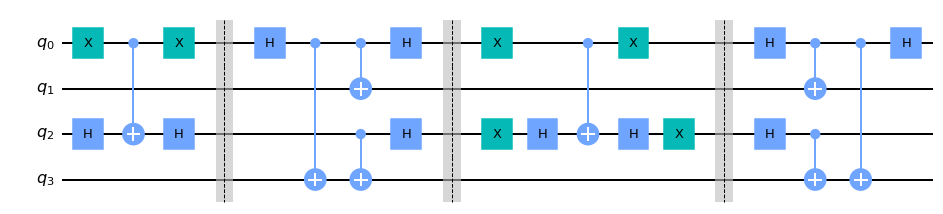

In [35]:
# build Q2 - third try
qr, qc = circ(4)
qc.x(0)
qc.h(2)
qc.cx(0, 2)
qc.h(2)
qc.x(0)
qc.barrier()
qc.compose(U_dag_circ, qr, inplace=True)
qc.barrier()
qc.compose(D2_circ, [0, 2], inplace=True)
qc.barrier()
qc.compose(U_circ, qr, inplace=True)
Q2_circ = deepcopy(qc)
# transpile(Q2_circ, backend=manila).draw()
Q2_circ.draw()

In [24]:
# see number of iterations of Q2 we need

# build list of circuits
circ_lst = []
qr, cr, qc = circ_measured(4, 4)
qc.compose(U_circ, qr, inplace=True)

## iteration 0 (does not have Q operator)
qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure(qr, cr)
circ_lst.append(qc_measured)

## iteration 1 (put correct contraction)
qc.compose(Q1_circ, qr, inplace=True)
qc_measured = deepcopy(qc)
qc_measured.barrier()
qc_measured.measure(qr, cr)
circ_lst.append(qc_measured)

for m in range(10):
    qc.compose(Q2_circ, qr, inplace=True)
    qc_measured = deepcopy(qc)
    qc_measured.barrier()
    qc_measured.measure(qr, cr)
    circ_lst.append(qc_measured)

In [25]:
job1 = execute(circ_lst, backend=sim, shots=20000)

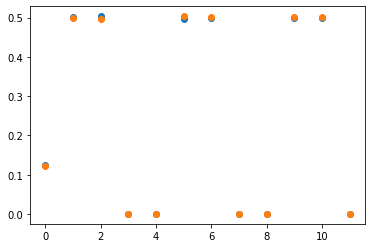

In [26]:
plt.plot(t.a_arr(counts(job1), '0110'),'o')
plt.plot(t.a_arr(counts(job1), '0000'),'o')

In [88]:
# job_id='61c34f2dbf935fab23644d32'
# job2 = execute(circ_lst, backend=manila, shots=20000)

job_id='61c34f2dbf935fab23644d32'


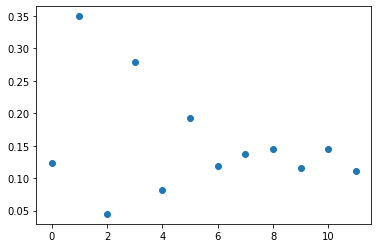

In [27]:
plt.plot(t.a_arr(counts(manila.retrieve_job('61c34f2dbf935fab23644d32')), '0.10'),'o')

In [28]:
job = manila.retrieve_job('61c34f2dbf935fab23644d32')

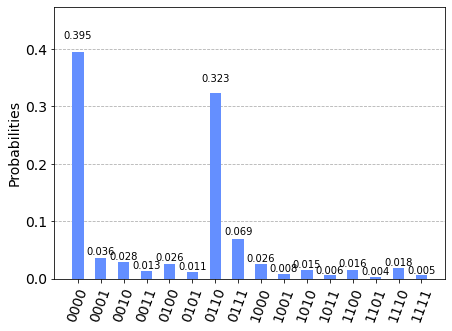

In [31]:
counts = job.result().get_counts()
plot_histogram(counts[1])

In [132]:
# check that this is better than regular

circs = t.ampl_circs(U_circ, '0.10')

In [135]:
job3 = execute(circs, backend=manila, shots=20000)
job_id(job3)

job_id='61c35ab2e867002378a00b68'


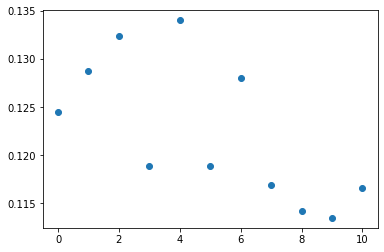

In [147]:
plt.plot(t.a_arr(counts(manila.retrieve_job('61c35ab2e867002378a00b68')), '0.10'),'o')